In [1]:
import  time
from    tqdm.notebook           import  tqdm

import  torch
from    torch                   import  Tensor
import  matplotlib.pyplot       as      plt
from    IPython                 import  display
from    ipywidgets              import  Output

import  find_library
from    torch_numerical.utils           import  *
from    torch_numerical.distribution    import  *
from    torch_numerical.solvers         import  *

DTYPE:  torch.dtype     = torch.float32
DEVICE: torch.device    = torch.device('cuda:2')
tensor_kwargs = {'dtype': DTYPE, 'device': DEVICE}

The following path will be appended.
>>> [/media/junseung/47a90e46-3a9d-467c-bbee-066752b68532/GWANGJAE/python_deep_numerical/pytorch/torch_numerical]
The following path will be appended.
>>> [/media/junseung/47a90e46-3a9d-467c-bbee-066752b68532/GWANGJAE/python_deep_numerical/pytorch]


In [2]:
# Time
DELTA_T:    float       = 0.01
MIN_T:      float       = 0.0
MAX_T:      float       = 10.0
NUM_T:      int         = int(1 + (MAX_T - MIN_T + 0.1*DELTA_T) / DELTA_T)
ARR_T:      Tensor      = torch.linspace(MIN_T, MAX_T, NUM_T, **tensor_kwargs)

# Velocity
DIMENSION:      int         = 2
RESOLUTION:     int         = 32
MAX_V:          float       = 3.0 / LAMBDA
V:              Tensor      = velocity_grid(
                                    DIMENSION,
                                    RESOLUTION,
                                    MAX_V,
                                    **tensor_kwargs
                                )

# Further configurations - FFT
FFT_NORM:   str         = 'forward'
_FREQ:      Tensor      = fft_index(RESOLUTION, **tensor_kwargs)
FREQ_MIN:   int         = int(_FREQ.min())
FREQ_MAX:   int         = int(_FREQ.max())
freqs:      Tensor      = freq_tensor(DIMENSION, RESOLUTION, **tensor_kwargs)
    
# VHS model
VHS_ALPHA:      float   = 0.0
VHS_COEFF:      float   = 1 / area_of_unit_sphere(DIMENSION)

# Metric
METRIC_ORDER:   float   = float('inf')


# Problem type
PROBLEM_TYPE:   str = 'bkw'
PROBLEM_TYPE = PROBLEM_TYPE.lower()

## BKW solution
BKW_COEFF_EXT:  float = get_bkw_coeff_ext(DIMENSION)

## Maxwellian distribution
MAXWELLIAN_MEAN_DENSITY:        float       = 1.0
MAXWELLIAN_MEAN_VELOCITY:       Tensor      = torch.zeros(DIMENSION, **tensor_kwargs)
MAXWELLIAN_MEAN_TEMPERATURE:    float       = 1.0

## Bimodal distribution
BIMODAL_MODE1_MEAN_DENSITY:     float       = 0.5
BIMODAL_MODE1_MEAN_VELOCITY:    Tensor      = torch.tensor([MAX_V/6, *zeros(DIMENSION-1)], **tensor_kwargs)
BIMODAL_MODE1_MEAN_TEMPERATURE: float       = 0.5

In [3]:
print(f"[ Initialization ]")
print(f"* Setting the initial value.")
arr_f:  Tensor
"""A space-homogeneous initial condition"""
if PROBLEM_TYPE == 'bkw':
    bkw_sol = bkw(
                    ARR_T, V,
                    coeff_ext   = BKW_COEFF_EXT,
                    vhs_coeff   = VHS_COEFF,
                )
    arr_f = bkw_sol[:, 0]
elif PROBLEM_TYPE == 'maxwellian':
    arr_f = maxwellian_homogeneous(
                V,
                MAXWELLIAN_MEAN_DENSITY,
                MAXWELLIAN_MEAN_VELOCITY,
                MAXWELLIAN_MEAN_TEMPERATURE,
            )
elif PROBLEM_TYPE == 'bimodal':
    arr_f = maxwellian_homogeneous(
                V,
                BIMODAL_MODE1_MEAN_DENSITY,
                +BIMODAL_MODE1_MEAN_VELOCITY,
                BIMODAL_MODE1_MEAN_TEMPERATURE,
            ) + \
            maxwellian_homogeneous(
                V,
                BIMODAL_MODE1_MEAN_DENSITY,
                -BIMODAL_MODE1_MEAN_VELOCITY,
                BIMODAL_MODE1_MEAN_TEMPERATURE,
            )

f_shape     = arr_f.shape[-(1+DIMENSION):-1]
f_axes_v    = tuple(range(-(1+DIMENSION), -1))


arr_f_fft: Tensor = torch.fft.fftn(arr_f, s=f_shape, dim=f_axes_v, norm=FFT_NORM)
"""The discrete Fourier transform of the solution sample"""

print(f"* Computing the kernel components.")
sm_object = FastSM_Boltzmann_VHS(
    dimension   = DIMENSION,
    v_num_grid  = 32,
    v_max       = MAX_V,
    vhs_coeff   = VHS_COEFF,
    vhs_alpha   = VHS_ALPHA,
    restitution = 1.0,
    
    quad_order_uniform  = 25,
    quad_order_legendre = 25,
    quad_order_lebedev  = 7,
    
    dtype   = DTYPE,
    device  = DEVICE,
)
print(f"\tDone. (approximation level: {sm_object.approximation_level})")

[ Initialization ]
* Setting the initial value.
----------[ BKW solution ]----------
* coeff_ext: 0.5
* coeff_int: 0.125
------------------------------------
* Computing the kernel components.
	Done. (approximation level: 625)


In [4]:
print(f"[ Computation ]")
print(f"* Computing the numerical solution.")
arr_distribution        = []
arr_mean_density        = []
arr_mean_velocity       = []
arr_mean_temperature    = []
arr_rel_error           = []

out = Output()
display.display(out)
output_period = 200**3

elapsed_time = time.time()

for cnt, t_curr in enumerate(tqdm(ARR_T)):
    # Backup the previous data and check if the terminal time has been reached
    arr_distribution.append(arr_f)
    
    rho, u, T = compute_moments_homogeneous(arr_f, V)
    arr_mean_density.append(rho)
    arr_mean_velocity.append(u)
    arr_mean_temperature.append(T)
    _target:    Tensor  = None
    if PROBLEM_TYPE == 'bkw':
        _target = bkw_sol[:, cnt]
    elif PROBLEM_TYPE == 'maxwellian':
        _target = arr_distribution[0]
    elif PROBLEM_TYPE == 'bimodal' and _target is None:
        _target = maxwellian_homogeneous(
            V,
            arr_mean_density[0],
            arr_mean_velocity[0],
            arr_mean_temperature[0],
        )
    arr_rel_error.append( relative_error(arr_f, _target).mean().item() )
    
    if cnt==0 or cnt%output_period==output_period-1:
        with out:
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            _title = f"Relative error of order {METRIC_ORDER:.2f} by epoch {cnt} ($t={t_curr:.2f}$)\n"
            if PROBLEM_TYPE != 'bimodal':
                _title += f"Maximum: {max(arr_rel_error):.4e}"
            else:
                _title += f"Minimum: {min(arr_rel_error):.4e}"
            axes[0].plot(ARR_T[:cnt+1].cpu(), arr_rel_error, 'r-', linewidth=1)
            axes[0].set_title(_title)
            axes[0].set_xlim(MIN_T, MAX_T)
            axes[0].set_ylim(1e-8, 1e-0)
            axes[0].set_yscale('log')
            axes[0].grid()
            if DIMENSION==2:
                _imshow_data = arr_f[0].cpu().reshape(RESOLUTION, RESOLUTION)
                ax = axes[1].imshow(_imshow_data, extent=[-MAX_V, MAX_V, MAX_V, -MAX_V], aspect='auto')
                fig.colorbar(ax)
                axes[1].set_xlabel('$v_y$')
                axes[1].set_ylabel('$v_x$')
            plt.tight_layout()
            plt.show()
            display.clear_output(wait=True)
    
    if cnt == NUM_T-1:
        break
    
    # Update the function
    arr_f_fft = sm_object.forward(t_curr, arr_f_fft, DELTA_T, one_step_RK4_classic)
    arr_f = torch.fft.ifftn(arr_f_fft, s=f_shape, dim=f_axes_v, norm=FFT_NORM).real

elapsed_time = time.time() - elapsed_time


ARR_T                   = ARR_T.cpu()
arr_distribution        = torch.stack(arr_distribution, dim=1).cpu()
arr_mean_density        = torch.stack(arr_mean_density, dim=1).cpu()
arr_mean_velocity       = torch.stack(arr_mean_velocity, dim=1).cpu()
arr_mean_temperature    = torch.stack(arr_mean_temperature, dim=1).cpu()
arr_rel_error           = torch.tensor(arr_rel_error, dtype=DTYPE).cpu()

print(f"\tDone. (Elapsed time: {elapsed_time:.2f} seconds)")

[ Computation ]
* Computing the numerical solution.


Output()

  0%|          | 0/1001 [00:00<?, ?it/s]

	Done. (Elapsed time: 4.60 seconds)


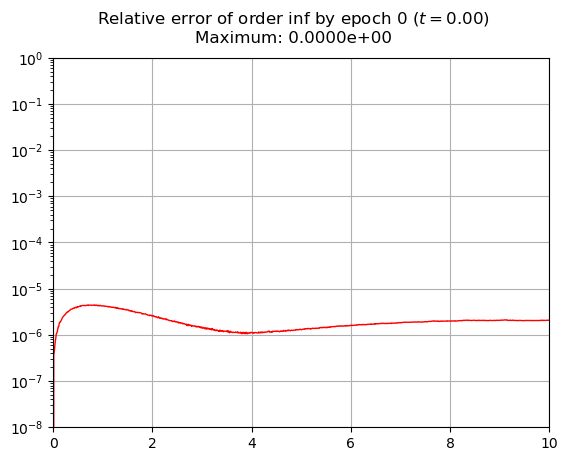

In [5]:
plt.plot(ARR_T, arr_rel_error, 'r-', linewidth=1)
plt.suptitle(_title)
plt.xlim(MIN_T, MAX_T)
plt.ylim(1e-8, 1e-0)
plt.grid(True)
plt.yscale('log')
plt.show()
display.clear_output(wait=True)

In [6]:
# np.savez(
#     file = f"FSM_{DIMENSION}D__{PROBLEM_TYPE}_res{RESOLUTION}_L{MAX_V:.2e}_T{MAX_T}_dt{DELTA_T:.2e}",
    
#     metric_order    = METRIC_ORDER,
#     elapsed_time    = elapsed_time,
    
#     min_t   = MIN_T,
#     max_t   = MAX_T,
#     delta_t = DELTA_T,
    
#     dim     = DIMENSION,
#     max_v   = MAX_V,
#     res     = RESOLUTION,
    
#     arr_distribution        = arr_distribution,
#     arr_mean_density        = arr_mean_density,
#     arr_mean_velocity       = arr_mean_velocity,
#     arr_mean_temperature    = arr_mean_temperature,
#     arr_rel_error           = arr_rel_error,
# )

End of file